In [1]:
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
import cartopy
import cartopy.crs as ccrs
from matplotlib.colors import LinearSegmentedColormap


In [2]:
ds = xr.open_dataset('./regional_data_temp.nc')
ds.load()

ds_weights=xr.open_dataset('./weights_temperature_test.nc')
ds_weights = ds_weights.to_array()

In [6]:
W=list()
UW=list()

#apply weights for each pseudo choice
for i_obs in range(27):
    #convert weights dataset to numpy array
    all_weights=np.asarray(ds_weights[0])
    
    
    #select pseudo weights from the saved weights
    weights=all_weights[i_obs,:]

    #select pseudo from the data
    ds_obs=ds.isel(model=i_obs)
    #select all models but the pseudo from the data
    v=np.delete(np.arange(27), i_obs)
    ds_gcm=ds.isel(model=v)

    #add the weights to the dataset
    ds_gcm=ds_gcm.assign({"weights": ("model",weights)})
    
    #apply the weights to the dataset
    ds_gcm=ds_gcm.assign(tas_fut_weights=ds_gcm.tas*ds_gcm.weights)
    
    #apply common baseline to the data
    ds_gcm = ds_gcm.sel(time=slice('2080', '2099')).mean(dim='time')-ds_gcm.sel(time=slice('1960', '2014')).mean(dim='time')
    
    #apply common baseline to the pseudo
    fut_period = ds_obs.sel(time=slice('2080', '2099')).mean(dim='time')-ds_obs.sel(time=slice('1960', '2014')).mean(dim='time')

    #find weighted mean difference
    y_w = np.abs(fut_period - ds_gcm.tas_fut_weights.sum('model'))
    #find unweighted mean difference
    y_uw = np.abs(fut_period - ds_gcm.tas.mean('model'))
    
    #add to list for this pseudo choice and move onto the next pseudo choice
    W.append(y_w)
    UW.append(y_uw)
    

Y_W = xr.concat(W, dim = 'model',coords='minimal',compat='override')
Y_UW = xr.concat(UW, dim = 'model',coords='minimal',compat='override')


<xarray.Dataset>
Dimensions:  (lat: 88, lon: 179)
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
Data variables:
    tas      (lat, lon) float64 0.181 0.1746 0.1678 ... 0.301 0.2999 0.3006


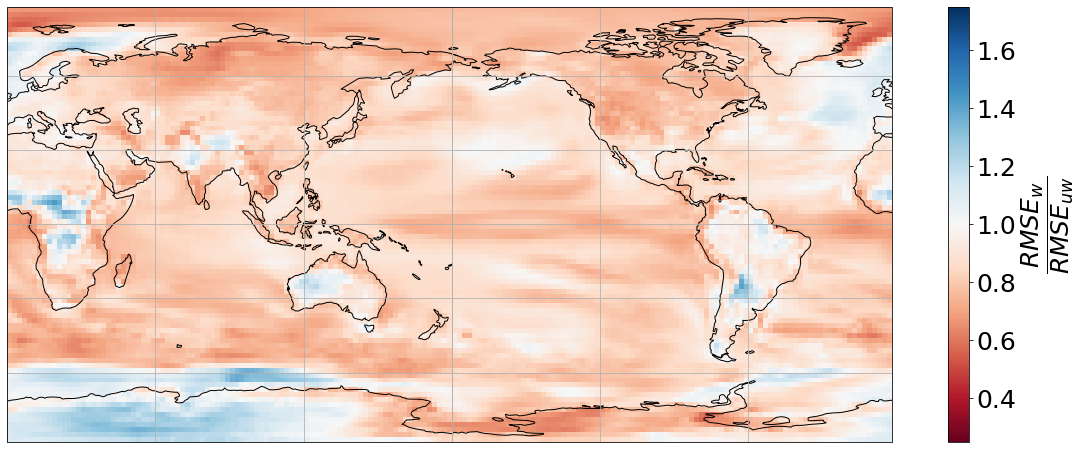

In [9]:
var = RMSE/RMSE_unweighted

#set colormap
color_map=plt.get_cmap('RdBu')

#set min and maxes for colorbar
vmin=0.25;
vmax=1.75;

#plot RMSE reduction
fig, ax = plt.subplots(1, 1, figsize=(20,8),subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
mesh = var.tas.plot(ax=ax,transform=ccrs.PlateCarree(),
                       cmap=color_map, vmin= vmin, vmax=vmax, add_colorbar=False)

ax.gridlines()
ax.coastlines(color='black')

cbar = fig.colorbar(mesh, ax=ax)
cbar.set_label('$\dfrac{RMSE_{w}}{RMSE_{uw}}$', fontsize=25) 
cbar.ax.tick_params(labelsize=25)




fig.savefig("reigonal_temp.png", dpi=400)